In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
from tqdm import tqdm
from datetime import datetime

from energymodel import (
    EnergyModel, EMSolver, random_uniform, LossMonitor, FantasyParticleMonitor,
    VectorFieldMonitor, LossGradientMonitor, NanMonitor, Lyapunov
)

tf.compat.v1.reset_default_graph()

## Dataset

In [2]:
def vector_field(z):
    x = z[:, 0][:, tf.newaxis]
    l = z[:, 1][:, tf.newaxis]

    dx = l * x + 2 * x**2 - x**3
    dl = tf.zeros_like(l)

    return tf.concat([dx, dl], axis=1)

input_shape = [2]
batch_size = 128
resample = lambda batch_size: 0.5 * random_uniform([batch_size, *input_shape])
solver = EMSolver(dt=1e-1, eps=1e-2)

lyapunov = Lyapunov(
    vector_field,
    resample(batch_size),
    solver,
    1e-1,
)

## Model

In [3]:
network = models.Sequential([
    layers.Dense(512),
    layers.Activation('swish'),

    layers.Dense(1, use_bias=False),
])
network(resample(batch_size))  # build.

model = EnergyModel(
    network,
    resample,
    solver,
    5e-0,
)
tf.print('T =', model.T)

optimizer = tf.keras.optimizers.Adam(1e-3, clipvalue=1e-1)
logdir = "logdir/" + datetime.now().strftime("%Y%m%d-%H%M%S")
writer = tf.summary.create_file_writer(logdir)
callbacks = [
    LossMonitor(writer, 5),
    FantasyParticleMonitor(writer, model, 5),
    VectorFieldMonitor(writer, model, 5),
    LossGradientMonitor(writer, model, 5),
    NanMonitor(5),
]

train_step = model.get_optimize_fn(optimizer, callbacks)
train_step = tf.function(train_step)

T = 0.0367310867


In [4]:
def criterion(test_batch):
    return tf.reduce_sum(model.vector_field(test_batch) * vector_field(test_batch), axis=1)

test_batch = resample(batch_size)

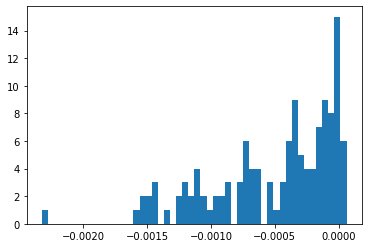

In [5]:
Y = criterion(test_batch)
plt.hist(Y.numpy(), bins=50)
plt.show()

In [6]:
# Two epochs are enough!
for step in tqdm(range(2000)):
    batch = lyapunov()
    if tf.greater(step, 500):
        train_step(batch)

100%|██████████| 2000/2000 [00:31<00:00, 63.05it/s]


## Evaluation

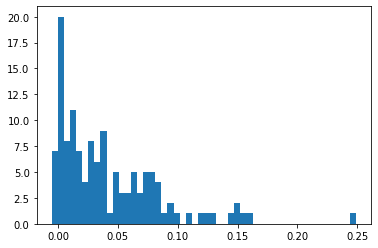

In [7]:
Y2 = criterion(test_batch)
plt.hist(Y2.numpy(), bins=50)
plt.show()